In [235]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm
from torchvision import datasets, transforms
import torch.nn
import torch.nn.functional as F

## MNIST Dataset

Use the PyTorch functions to download the data.

In [236]:
mnist_train = datasets.MNIST(root="./datasets", train=True, transform=transforms.ToTensor(), download=True)
mnist_test = datasets.MNIST(root="./datasets", train=False, transform=transforms.ToTensor(), download=True)

### Visualizing the data

Number of MNIST training examples: 60000
Number of MNIST test examples: 10000

mnist train has two piece of informantion: data and targets:
    mnist train data shape: torch.Size([60000, 28, 28])
    mnist train targets shape: torch.Size([60000])

Default image shape: torch.Size([1, 28, 28])
Squeezed image shape: torch.Size([28, 28])
The label for this image: 1


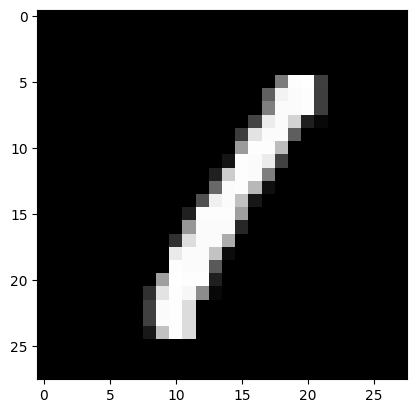

In [237]:
print(f"Number of MNIST training examples: {len(mnist_train)}")
print(f"Number of MNIST test examples: {len(mnist_test)}")

print("")

print(f"mnist train has two piece of informantion: data and targets:")
print(f"    mnist train data shape: {mnist_train.data.shape}")
print(f"    mnist train targets shape: {mnist_train.targets.shape}")

print("")

image, label = mnist_train[3] # select a data entry
print(f"Default image shape: {image.shape}")
image = torch.squeeze(image) # remove the 1 shape entries
print(f"Squeezed image shape: {image.shape}")
plt.imshow(image.view(28, 28), cmap="gray")

print(f"The label for this image: {label}")

## Separating and shuffling the data

In [238]:
n_features = image.shape[0] * image.shape[1]
n_labels = len(mnist_train.classes)
n_samples = len(mnist_train)
batch_size = 100

train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

print(f"n_features = {n_features}")
print(f"n_labels = {n_labels}")
print(f"n_samples = {n_samples}")
print(f"batch_size = {batch_size}")

n_features = 784
n_labels = 10
n_samples = 60000
batch_size = 100


In [239]:
data_train_iter = iter(train_loader)
x, l = next(data_train_iter)

print("Shape of the minibatch of images: {}".format(x.shape))
print("Shape of the minibatch of labels: {}".format(l.shape))

Shape of the minibatch of images: torch.Size([100, 1, 28, 28])
Shape of the minibatch of labels: torch.Size([100])


## Logistic Regression

## Initialize parameters

In [240]:
# initialize weights W - xavier initialization
W = torch.randn(n_features, n_labels)/np.sqrt(n_features)
W.requires_grad_()

# Initialize bias b as 0s
b = torch.zeros(1, n_labels, requires_grad=True)

# logs
print(f"W.shape = {W.shape}")
print(f"b.shape = {b.shape}")

W.shape = torch.Size([784, 10])
b.shape = torch.Size([1, 10])


## Processing one sample

In [241]:
# get one instance
samples_batch, l_batch = next(iter(train_loader))
l = l_batch[0]
x = samples_batch[0].view(-1, n_features)

# Linear transformation with W and b
print("The shape of input x: {}".format(x.shape))
z = torch.matmul(x, W) + b
y = torch.softmax(z, dim=1)

# logs
print(f"l.shape = {l.shape}")
print(f"x.shape = {x.shape}")
print(f"z.shape = {z.shape}")
print(f"y.shape = {y.shape}")

# one example
print("\none example of output:")
print(f"l = {l}")
# print(f"x = {x}")
print(f"z = {z}")
print(f"y = {y}")
print(f"max index = {torch.argmax(y).item()}")

The shape of input x: torch.Size([1, 784])
l.shape = torch.Size([])
x.shape = torch.Size([1, 784])
z.shape = torch.Size([1, 10])
y.shape = torch.Size([1, 10])

one example of output:
l = 3
z = tensor([[-0.2647,  0.0607, -0.2129, -0.3208,  0.6360,  0.4303,  0.5860,  0.1966,
          0.1096, -0.7756]], grad_fn=<AddBackward0>)
y = tensor([[0.0674, 0.0934, 0.0710, 0.0638, 0.1660, 0.1351, 0.1579, 0.1070, 0.0980,
         0.0405]], grad_fn=<SoftmaxBackward0>)
max index = 4


In [242]:
# cross-entropy

print("by hand")
yc = torch.zeros(1, n_labels)
yc[0,l] = 1
H = torch.sum(-yc * torch.log(y))
print(f"H = {H}")

print("")

print("pytorch")
H = F.cross_entropy(z[0,:], l) # [0,:] is required because z has 1 batch
print(f"H = {H}")

by hand
H = 2.752683639526367

pytorch
H = 2.752683639526367


## Processing one batch

In [243]:
# get one instance
x, l = next(iter(train_loader))
x = x.view(-1, n_features)

# Linear transformation with W and b
z = torch.matmul(x, W) + b
y = torch.softmax(z, dim=1)

# logs
print(f"x.shape = {x.shape}")
print(f"z.shape = {z.shape}")
print(f"y.shape = {y.shape}")
print(f"l.shape = {l.shape}")

x.shape = torch.Size([100, 784])
z.shape = torch.Size([100, 10])
y.shape = torch.Size([100, 10])
l.shape = torch.Size([100])


In [244]:
# cross-entropy

## by hand
print("by hand")
H = torch.mean(-torch.log(y)[range(l.shape[0]),l])
print(f"H = {H}")

print("")

print("pytorch")
H = F.cross_entropy(z, l)
print(f"H = {H}")

by hand
H = 2.3262884616851807

pytorch
H = 2.3262887001037598


# Optimizing

In [245]:
# reinitialize W and b
W = torch.randn(n_features, n_labels)/np.sqrt(n_features)
W.requires_grad_()
b = torch.zeros(1, n_labels, requires_grad=True)

# optimize
learning_rate = 0.1
opt = torch.optim.SGD([W,b], lr=learning_rate) # initialize

# Iterate through train set minibatchs 
for x, l in tqdm(train_loader):
    opt.zero_grad()
    # Forward pass - compute the cross entropy for a batch
    x = x.view(-1, n_features) # rescale the input
    z = torch.matmul(x, W) + b # compute model output
    H = F.cross_entropy(z, l) # compute cross-entropy
    # Backward pass - update values of W, b
    H.backward() # compute gradient
    opt.step() # perform an optimization step, i.e. update W and b

  0%|          | 0/600 [00:00<?, ?it/s]

In [246]:
# test

correct = 0
total = len(mnist_test)

with torch.no_grad():
    # Iterate through test set minibatchs 
    for x, lp in tqdm(test_loader):
        x = x.view(-1, n_features) # rescale the input
        z = torch.matmul(x, W) + b # compute model output
        l = torch.argmax(z, dim=1) # get the output labels
        correct += torch.sum((l == lp).float()) # count how many were correct
    
print(f"Test accuracy: {100 * correct / total} %")

  0%|          | 0/100 [00:00<?, ?it/s]

Test accuracy: 90.19999694824219 %


# plot filters

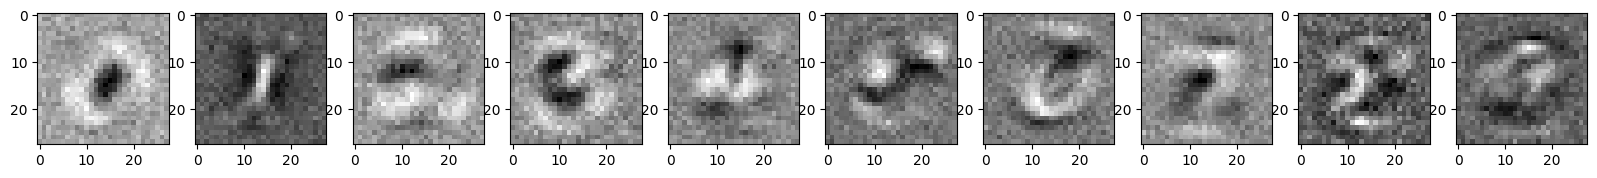

In [247]:
# Get weights
fig, ax = plt.subplots(1, 10, figsize=(20, 2))

for digit in range(10):
    ax[digit].imshow(W[:,digit].detach().view(28,28), cmap='gray')

# Full code

n_features = 784
n_labels = 10
n_samples = 60000
batch_size = 100


  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Test accuracy: 90.23999786376953 %


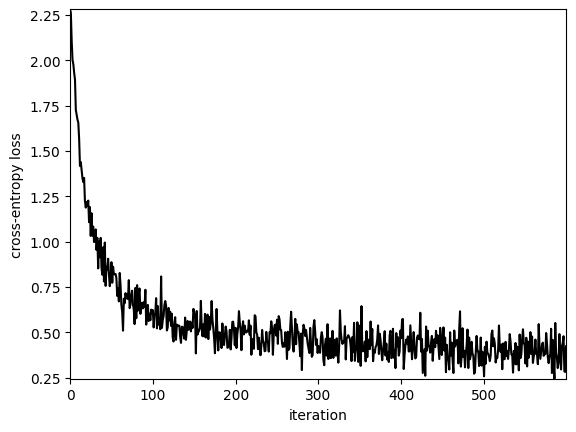

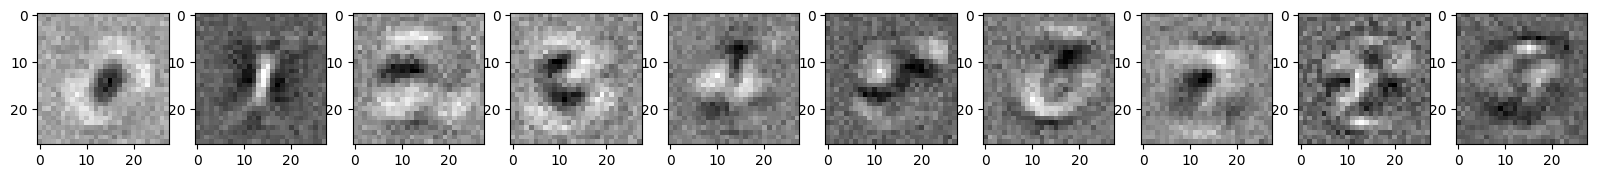

In [257]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch
import torch.nn
import torch.nn.functional as F
from torchvision import datasets, transforms

# user defined parameters
debug = True
learning_rate = 0.1
batch_size = 100

# load data
mnist_train = datasets.MNIST(root="./datasets", train=True, transform=transforms.ToTensor(), download=True)
mnist_test = datasets.MNIST(root="./datasets", train=False, transform=transforms.ToTensor(), download=True)

# parameters
n_features = mnist_train[0][0].shape[1] * mnist_train[0][0].shape[2]
n_labels = len(mnist_train.classes)
n_samples = len(mnist_train)
if debug:
    print(f"n_features = {n_features}")
    print(f"n_labels = {n_labels}")
    print(f"n_samples = {n_samples}")
    print(f"batch_size = {batch_size}")

# data loader
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

# initialize model parameters
W = torch.randn(n_features, n_labels) / np.sqrt(n_features)
W.requires_grad_()
b = torch.zeros(1, n_labels, requires_grad=True)

# optimize
opt = torch.optim.SGD([W,b], lr=learning_rate)
H_history = []
for x, l in tqdm(train_loader):
    opt.zero_grad()
    x = x.view(-1, n_features)
    z = torch.matmul(x, W) + b
    H = F.cross_entropy(z, l)
    H_history.append(H.item())
    H.backward()
    opt.step()

# test
correct = 0
total = len(mnist_test)
with torch.no_grad():
    for x, lp in tqdm(test_loader):
        x = x.view(-1, n_features)
        z = torch.matmul(x, W) + b
        l = torch.argmax(z, dim=1)
        correct += torch.sum((l == lp).float())

if debug:
    print(f"Test accuracy: {100 * correct / total} %")

# plot cross-entropy history
if debug:
    x = np.arange(len(H_history))
    y = np.array(H_history)
    plt.plot(x, y, 'k-')
    plt.xlim([0, np.max(x)])
    plt.ylim([np.min(y), np.max(y)])
    plt.xlabel("iteration")
    plt.ylabel("cross-entropy loss")
    plt.show()
    plt.close()

# plot filters
if debug:
    fig, ax = plt.subplots(1, 10, figsize=(20, 2))
    for digit in range(10):
        ax[digit].imshow(W[:,digit].detach().view(28,28), cmap='gray')
    plt.show()
    plt.close()
